In [1]:
import numpy as np
from mrashpen.models.plr_ash import PenalizedMrASH as PenMrASH
from mrashpen.models.normal_means_ash import NormalMeansASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [2]:
def _ash_data(n = 100, p = 200, p_causal = 5, pve = 0.5, rho = 0.0, k = 6, seed = None): 

    def sd_from_pve (X, b, pve):
        return np.sqrt(np.var(np.dot(X, b)) * (1 - pve) / pve)

    ''' 
    ASH prior
    '''
    if seed is not None:
        np.random.seed(seed)
    wk = np.zeros(k)
    wk[1:(k-1)] = np.repeat(1/(k-1), (k - 2)) 
    wk[k-1] = 1 - np.sum(wk)
    sk = np.arange(k)
    ''' 
    Equicorr predictors
    X is sampled from a multivariate normal, with covariance matrix V.
    V has unit diagonal entries and constant off-diagonal entries rho.
    '''
    iidX    = np.random.normal(size = n * p).reshape(n, p)
    comR    = np.random.normal(size = n).reshape(n, 1)
    X       = comR * np.sqrt(rho) + iidX * np.sqrt(1 - rho)
    bidx    = np.random.choice(p, p_causal, replace = False)
    b       = np.zeros(p)
    b[bidx] = np.random.normal(size = p_causal)
    sigma   = sd_from_pve(X, b, pve)
    y       = np.dot(X, b) + sigma * np.random.normal(size = n)
    return X, y, b, sigma, wk, sk

def _NM_data_scaled(n = 100, s = 1.2, k = 6):
    np.random.seed(100)
    y = np.random.normal(0, 1, size = n)
    X = np.random.normal(0, 1, size = (n, 2000))
    d = np.sum(np.square(X), axis = 1)
    wk = np.zeros(k)
    wk[1:(k-1)] = np.repeat(1/(k-1), (k - 2)) 
    wk[k-1] = 1 - np.sum(wk)
    sk = np.arange(k)
    return y, s, wk, sk, d

def _NM_data(n = 100, s = 1.2, k = 6):
    np.random.seed(100)
    y = np.random.normal(0, 1, size = n)
    wk = np.zeros(k)
    wk[1:(k-1)] = np.repeat(1/(k-1), (k - 2)) 
    wk[k-1] = 1 - np.sum(wk)
    sk = np.arange(k)
    return y, s, wk, sk

In [3]:
y, s, wk, sk, dj = _NM_data_scaled()
eps = 1e-8

In [4]:
nmash = NormalMeansASHScaled(y, s, wk, sk, d = dj)
nmash_eps = NormalMeansASHScaled(y + eps, s, wk, sk, d = dj)
deriv_analytic  = nmash.logML_deriv
deriv_numeric   = (nmash_eps.logML - nmash.logML) / eps
np.allclose(deriv_analytic, deriv_numeric, atol = 1e-8, rtol = 1e-4)

True

In [5]:
nmash = NormalMeansASHScaled(y, s, wk, sk, d = dj)
nmash_eps = NormalMeansASHScaled(y + eps, s, wk, sk, d = dj)
deriv_analytic  = nmash.logML_deriv2
deriv_numeric   = (nmash_eps.logML_deriv - nmash.logML_deriv) / eps
np.allclose(deriv_analytic, deriv_numeric, atol = 1e-8, rtol = 1e-5)

True

In [6]:
nmash = NormalMeansASHScaled(y, s, wk, sk, d = dj) 
for i in range(wk.shape[0]):
    wkeps = wk.copy()
    wkeps[i] += eps 
    nmash_eps = NormalMeansASHScaled(y, s, wkeps, sk, d = dj) 
    deriv_analytic = nmash.logML_wderiv[:, i]
    deriv_numeric  = (nmash_eps.logML - nmash.logML) / eps
    success = np.allclose(deriv_analytic, deriv_numeric, atol = 1e-6, rtol = 1e-5)
    print (f"k = {i}, success = {success}, diff = {np.max(np.abs(deriv_analytic - deriv_numeric))}")

k = 0, success = True, diff = 4.774293888942793e-05
k = 1, success = True, diff = 8.14509890645354e-08
k = 2, success = True, diff = 6.83272081136721e-08
k = 3, success = True, diff = 5.660049029465597e-08
k = 4, success = True, diff = 6.13434018026382e-08
k = 5, success = True, diff = 5.3522881682255274e-08


In [7]:
nmash = NormalMeansASHScaled(y, s, wk, sk, d = dj) 
for i in range(wk.shape[0]):
    wkeps = wk.copy()
    wkeps[i] += eps 
    nmash_eps = NormalMeansASHScaled(y, s, wkeps, sk, d = dj) 
    deriv_analytic = nmash.logML_deriv_wderiv[:, i]
    deriv_numeric  = (nmash_eps.logML_deriv - nmash.logML_deriv) / eps
    success = np.allclose(deriv_analytic, deriv_numeric, atol = 1e-6, rtol = 1e-5)
    print (f"k = {i}, success = {success}, diff = {np.max(np.abs(deriv_analytic - deriv_numeric))}")

k = 0, success = True, diff = 0.001616946047761303
k = 1, success = True, diff = 3.778925738995298e-08
k = 2, success = True, diff = 1.9898045044985935e-08
k = 3, success = True, diff = 3.103573087415157e-08
k = 4, success = True, diff = 2.6119903628885055e-08
k = 5, success = True, diff = 2.61331651318919e-08


In [8]:
nmash = NormalMeansASHScaled(y, s, wk, sk, d = dj)
nmash_eps = NormalMeansASHScaled(y, s, wk, sk, d = dj)
nmash_eps.set_s2_eps(eps)
deriv_analytic = nmash.logML_s2deriv
deriv_numeric  = (nmash_eps.logML - nmash.logML) / eps
np.allclose(deriv_analytic, deriv_numeric, atol = 1e-8, rtol = 1e-5)

True

In [9]:
nmash = NormalMeansASHScaled(y, s, wk, sk, d = dj)
seps = np.sqrt(s * s + eps)
nmash_eps = NormalMeansASHScaled(y, seps, wk, sk, d = dj)
deriv_analytic = nmash.logML_deriv_s2deriv
deriv_numeric  = (nmash_eps.logML_deriv - nmash.logML_deriv) / eps
np.allclose(deriv_analytic, deriv_numeric, atol = 1e-8, rtol = 1e-5)

True

In [10]:
X, y, b, s, wk, sk = _ash_data(seed = 100)
n, p = X.shape

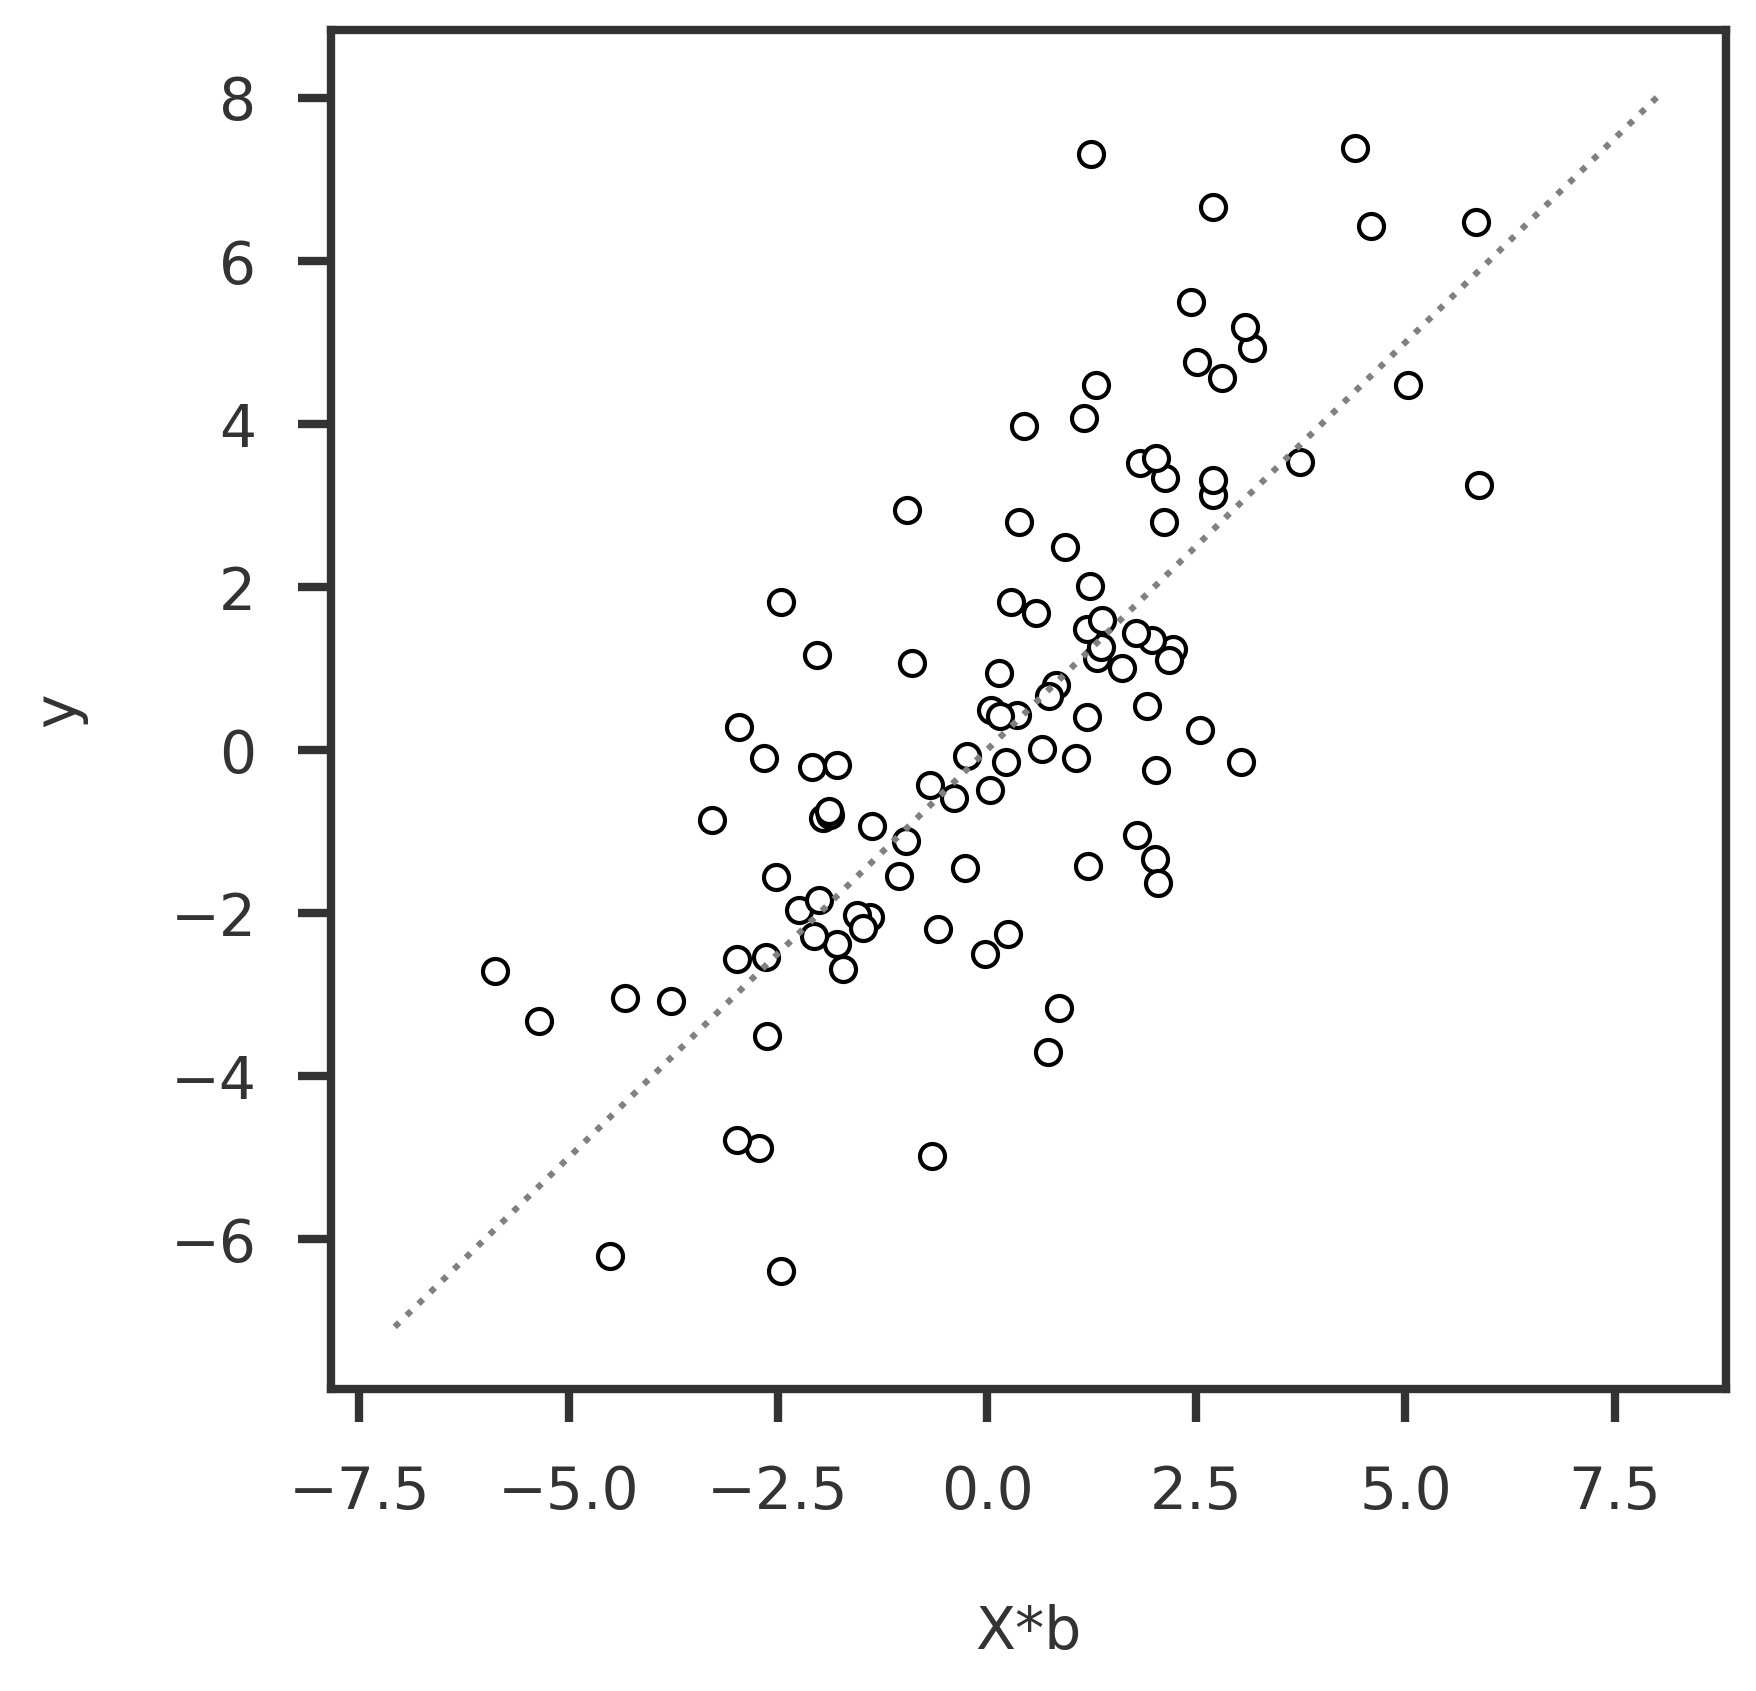

In [11]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(X, b), y, edgecolor = 'black', facecolor='white', label="ytest")
# ax1.plot(np.arange(X.shape[0]), np.dot(X, b), label="True")
# ax1.legend()
ax1.set_xlabel("X*b")
ax1.set_ylabel("y")
mpl_utils.plot_diag(ax1)
plt.show()

In [12]:
pmash = PenMrASH(X, y, b, s, wk, sk, is_prior_scaled = True)
obj = pmash.objective
bgrad, wgrad, s2grad = pmash.gradients
s2grad

2021-09-09 19:39:01,276 | mrashpen.models.plr_ash | DEBUG | Calculating PLR objective with sigma2 = 5.558411966249681


2.2078350461599783

In [13]:
dj = np.sum(np.square(X), axis = 0)
nmash = NormalMeansASHScaled(b, s, wk, sk, d = dj)
M, M_bgrad, M_wgrad, M_s2grad = pmash.shrinkage_operator(nmash)
l, l_bgrad, l_wgrad, l_s2grad = pmash.penalty_operator(nmash)
r   = y - np.dot(X, M)
rTr = np.sum(np.square(r))
rTX = np.dot(r.T, X)
r_s2grad = - 0.5 * rTr / (s * s * s * s) - np.dot(rTX, M_s2grad) / (s * s)
d_analytic = 0.5 * (n - p) / (s * s)
s2grad_analytic = r_s2grad + np.sum(l_s2grad) + d_analytic
s2grad_analytic

2.2078350461599783

In [14]:
eps = 1e-8
dj = np.sum(np.square(X), axis = 0)
pmash = PenMrASH(X, y, b, s, wk, sk, is_prior_scaled = True)
nmash = NormalMeansASHScaled(b, s, wk, sk, d = dj)
nmash_eps = NormalMeansASHScaled(b, s, wk, sk, d = dj)
nmash_eps.set_s2_eps(eps)
pmash_eps = PenMrASH(X, y, b, s, wk, sk, is_prior_scaled = True)
pmash_eps.set_s2_eps(eps)

In [15]:
M, M_bgrad, M_wgrad, M_s2grad = pmash.shrinkage_operator(nmash)
M_eps, _, _, _ = pmash_eps.shrinkage_operator(nmash_eps)
M_s2grad_numeric = (M_eps - M) / eps
np.allclose(M_s2grad, M_s2grad_numeric, atol = 1e-6)

True

In [16]:
r = y - np.dot(X, M)
rTr = np.sum(np.square(r))
rTX = np.dot(r.T, X)
obj1 = 0.5 * rTr / (s * s)

r_eps = y - np.dot(X, M_eps)
rTr_eps = np.sum(np.square(r_eps))
rTX_eps = np.dot(r_eps.T, X)
obj1_eps = 0.5 * rTr_eps / (s * s + eps)

In [17]:
r_s2grad_numeric = (obj1_eps - obj1) / eps

r_s2grad_numeric

-6.735505309052314

In [18]:
r_s2grad = - 0.5 * rTr / (s * s * s * s) - np.dot(rTX, M_s2grad) / (s * s)

r_s2grad

-6.7355060378664255

In [19]:
t1diff = r_s2grad - r_s2grad_numeric

In [20]:
l, l_bgrad, l_wgrad, l_s2grad = pmash.penalty_operator(nmash)
l_eps, _, _, _ = pmash_eps.penalty_operator(nmash_eps)
l_s2grad_numeric = (l_eps - l) / eps
t2diff = np.sum(l_s2grad) - np.sum(l_s2grad_numeric)

In [21]:
f = 0.5 * (n - p) * np.log(2 * np.pi * s * s)
f_eps = 0.5 * (n - p) * np.log(2 * np.pi * ((s * s) + eps))
d_numeric = (f_eps - f) / eps
d_analytic = 0.5 * (n - p) / (s * s)
t3diff = d_analytic - d_numeric

In [22]:
s2grad_analytic = r_s2grad + np.sum(l_s2grad) + d_analytic
s2grad_analytic

2.2078350461599783

In [23]:
s2grad_numeric = r_s2grad_numeric + np.sum(l_s2grad_numeric) + d_numeric
s2grad_numeric

2.2078327610586257

In [24]:
eps = 1e-4
pmash = PenMrASH(X, y, b, s, wk, sk, is_prior_scaled = True)
obj = pmash.objective
bgrad, wgrad, s2grad = pmash.gradients
bgrad_numeric = np.zeros(X.shape[1])
for i in range(X.shape[1]):
    bnew = b.copy()
    bnew[i] += eps
    pmash_beps = PenMrASH(X, y, bnew, s, wk, sk, debug = False, is_prior_scaled = True)
    bgrad_numeric[i] = (pmash_beps.objective - obj) / eps
wgrad_numeric = np.zeros(wk.shape[0])
for i in range(wk.shape[0]):
    wknew = wk.copy()
    wknew[i] += eps
    pmash_weps = PenMrASH(X, y, b, s, wknew, sk, debug = False, is_prior_scaled = True)
    wgrad_numeric[i] = (pmash_weps.objective - obj) / eps
pmash_s2eps = PenMrASH(X, y, b, s, wk, sk, debug = False, is_prior_scaled = True)
pmash_s2eps.set_s2_eps(eps)
s2grad_numeric = (pmash_s2eps.objective - obj) / eps

2021-09-09 19:39:01,348 | mrashpen.models.plr_ash | DEBUG | Calculating PLR objective with sigma2 = 5.558411966249681


In [25]:
pmash = PenMrASH(X, y, b, s, wk, sk, is_prior_scaled = True)
obj = pmash.objective

2021-09-09 19:39:01,480 | mrashpen.models.plr_ash | DEBUG | Calculating PLR objective with sigma2 = 5.558411966249681


In [26]:
np.allclose(bgrad, bgrad_numeric, atol = 1e-2, rtol = 1e-2)

True

In [27]:
np.allclose(wgrad, wgrad_numeric, atol = 1e-2, rtol = 1e-2)

True

In [28]:
s2grad

2.2078350461599783

In [29]:
s2grad_numeric

2.2078762242472294